# Лабораторная работа №1. 

Данная лабораторная работа состоит из нескольких блоков. В каждом блоке вам предлагается произвести некоторые манипуляции с данными и сделать некоторые выводы.
* Задавать вопросы можно и нужно.
* Списывать не нужно. Работы, которые были списаны обнуляются.
* Блоки выполняются последовательно и оцениваются отдельно.

## Часть 3. Градиентный бустинг

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset.

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [4]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [5]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [6]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [ ]:
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic/homeworks/Lab1_Ensembles_and_SVM/unique_columns.txt

In [7]:
unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [8]:
pca = PCA(0.99)

In [9]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [10]:
X_train_pca.shape

(7352, 179)

In [11]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

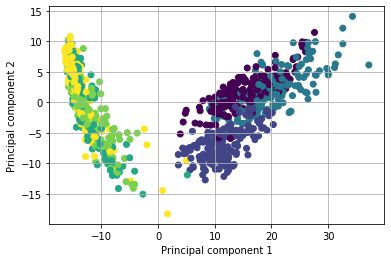

In [12]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

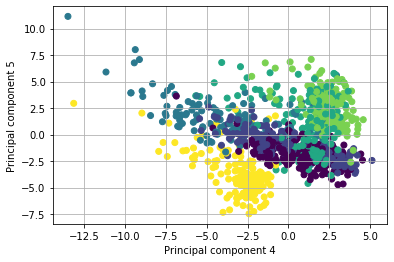

In [13]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)

model = xgb.XGBClassifier(max_depth=7, n_estimators=600)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }

search_params = RandomizedSearchCV(model, param_distributions = params, n_iter = param_comb,
                                   scoring = 'accuracy', cv = skf.split(X_train_pca, y_train), 
                                   n_jobs = -1, iid = False, verbose = 3, random_state = 0)
search_params.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 42.7min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0xa1863a9a8>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=7, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=None,
                                           objective...
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
               

In [30]:
search_params.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [31]:
y_pred = search_params.predict(X_test_pca)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.92%
